# Attempt 2

Basic example:
Taken from https://docs.sciml.ai/DiffEqFlux/stable/examples/neural_ode/

In [20]:
using Random, Distributions, LinearAlgebra

In [21]:
# using ComponentArrays, Lux, DiffEqFlux, OrdinaryDiffEq, Optimization, OptimizationOptimJL,
      OptimizationOptimisers, Random, Plots

(OptimizationOptimisers, Random, Plots)

In [22]:
# rng = Xoshiro(0)
# u0 = Float32[2.0; 0.0]
# datasize = 30
# tspan = (0.0f0, 1.5f0)
# tsteps = range(tspan[1], tspan[2]; length = datasize)

# function trueODEfunc(du, u, p, t)
#     true_A = [-0.1 2.0; -2.0 -0.1]
#     du .= ((u .^ 3)'true_A)'
# end

# prob_trueode = ODEProblem(trueODEfunc, u0, tspan)
# ode_data = Array(solve(prob_trueode, Tsit5(); saveat = tsteps))

# dudt2 = Chain(x -> x .^ 3, Dense(2, 50, tanh), Dense(50, 2))
# p, st = Lux.setup(rng, dudt2)
# prob_neuralode = NeuralODE(dudt2, tspan, Tsit5(); saveat = tsteps)

# function predict_neuralode(p)
#     Array(prob_neuralode(u0, p, st)[1])
# end

# function loss_neuralode(p)
#     pred = predict_neuralode(p)
#     loss = sum(abs2, ode_data .- pred)
#     return loss, pred
# end

# # Do not plot by default for the documentation
# # Users should change doplot=true to see the plots callbacks
# callback = function (p, l, pred; doplot = false)
#     println(l)
#     # plot current prediction against data
#     if doplot
#         plt = scatter(tsteps, ode_data[1, :]; label = "data")
#         scatter!(plt, tsteps, pred[1, :]; label = "prediction")
#         display(plot(plt))
#     end
#     return false
# end


In [23]:

# pinit = ComponentArray(p)
# callback(pinit, loss_neuralode(pinit)...; doplot = true)

# # use Optimization.jl to solve the problem
# adtype = Optimization.AutoZygote()

# optf = Optimization.OptimizationFunction((x, p) -> loss_neuralode(x), adtype)
# optprob = Optimization.OptimizationProblem(optf, pinit)

# result_neuralode = Optimization.solve(
#     optprob, OptimizationOptimisers.Adam(0.05); callback = callback, maxiters = 300)

# optprob2 = remake(optprob; u0 = result_neuralode.u)

# result_neuralode2 = Optimization.solve(
#     optprob2, Optim.BFGS(; initial_stepnorm = 0.01); callback, allow_f_increases = false)

# callback(result_neuralode2.u, loss_neuralode(result_neuralode2.u)...; doplot = true)

# Our Attempt

In [24]:
# Slava's code (slava_sim.py) converted to Julia using ChatGPT
function GenerateSwitchTimes(T, tt, μ, λ, pi0)
    curr_state = findfirst(pi0 .== 1) - 1  # Julia indices are 1-based
    switch_times = Dict(0.0 => curr_state)
    curr_time = 0.0
    
    while curr_time < T
        wait = curr_state == 0 ? rand(Exponential(1/μ)) : rand(Exponential(1/λ))
        curr_state = 1 - curr_state
        curr_time += wait
        switch_times[curr_time] = curr_state
    end
    
    return switch_times
end

function GetSingleCompTrajectory(T, tt, μ, λ, pi0)
    switch_times = GenerateSwitchTimes(T, tt, μ, λ, pi0)
    mykeys = collect(keys(switch_times))
    sort!(mykeys)
    times = range(0, T, length=tt)
    data = fill(-1, tt)
    
    for i in 1:tt
        time = times[i]
        idd = findlast(x -> x <= time, mykeys)
        data[i] = switch_times[mykeys[idd]]
    end
    
    return data
end;

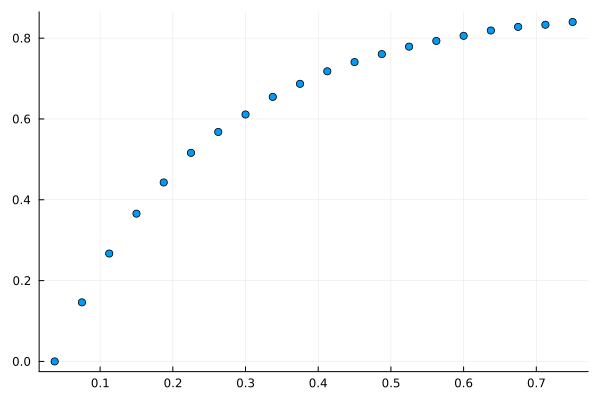

In [31]:
# Parameters
n = 2      # num of components
T = 0.75   # time horizon
tt = 20   # num of intervals in [0,T]
N = 10^4   # num of simulations
pi0 = [1, 0]  # initial distribution
λ, μ = 1, 2
t_δ = T/tt
t_range = t_δ:t_δ:T

ell = zeros(N, tt)

for j in 1:N
    trj = zeros(n, tt)
    for i in 1:n
        trj[i, :] = GetSingleCompTrajectory(T, tt, μ, λ, pi0)
    end
    ell[j, :] = sum(trj, dims=1) .> 0
end

r̂ = vec(mean(ell, dims=1))
scatter(t_range, r̂, label= false)

In [26]:
function f(t, x, i, P, π0)
    return (π0 * P(t))[i]^(1 - x)
end

function f_prime(t, x, i, P, π0, μ, λ)
    return -(1 - x) * μ * exp(-(μ + λ) * t) * 
           (λ / (μ + λ) + μ * exp(-(μ + λ) * t))^(-x)
end

function r_prime(t, n, ψ, P, π0, μ, λ)
    r_prime_sum = 0.0
    for x in Iterators.product(fill([0,1], n)...)  # Iterate over {0,1}^n
        x = collect(x)  # Convert tuple to array
        product_f = prod(f(t, x[i ÷ 2 + 1], i % 2, P, π0) for i in 0:2n-1)
        sum_f_prime_ratio = sum(f_prime(t, x[i ÷ 2 + 1], i % 2, P, π0, μ, λ) / f(t, x[i ÷ 2 + 1], i % 2, P, π0) for i in 0:2n-1)
        
        r_prime_sum += ψ(x) * product_f * sum_f_prime_ratio
    end
    return r_prime_sum
end

r_prime (generic function with 1 method)

# Back to basic

In [28]:
# rng = Xoshiro(0)
# u0 = Float32[1.0; 1.0]
# datasize = 30
# tspan = (0.0f0, 5f0)
# tsteps = range(tspan[1], tspan[2]; length = datasize)

# # function trueODEfunc(du, u, p, t)
# #     du[1] = -0.7*u[1] #+ 0.6*u.^3
# #     du[2] = -0.2*u[2]
# #     return du
# # end

# function trueODEfunc(du, u, p, t)
#     true_A = [-0.1 2.0; -2.0 -0.1]
#     du .= ((u .^ 3)'true_A)'
# end

# prob_trueode = ODEProblem(trueODEfunc, u0, tspan)
# ode_data = Array(solve(prob_trueode, Tsit5(); saveat = tsteps))
# plot(tsteps, ode_data', label = ["x1" "x2"])

In [27]:
# # dudt2 = Chain(x -> x, Dense(2, 20, tanh), Dense(20, 2))
# dudt2 = Chain(x -> x .^ 3, Dense(2, 50, tanh), Dense(50, 2))

# p, st = Lux.setup(rng, dudt2)
# prob_neuralode = NeuralODE(dudt2, tspan, Tsit5(); saveat = tsteps)

# function predict_neuralode(p)
#     Array(prob_neuralode(u0, p, st)[1])
# end

# function loss_neuralode(p)
#     pred = predict_neuralode(p)
#     loss = sum(abs2, ode_data .- pred)
#     return loss#, pred
# end

# # Do not plot by default for the documentation
# # Users should change doplot=true to see the plots callbacks
# callback = function (p, l, pred; doplot = false)
#     println(l)
#     # plot current prediction against data
#     if doplot
#         plt = scatter(tsteps, ode_data[1, :]; label = "data")
#         scatter!(plt, tsteps, pred[1, :]; label = "prediction")
#         display(plot(plt))
#     end
#     return false
# end;

In [29]:
# pinit = ComponentArray(p)
# callback(pinit, loss_neuralode(pinit)...; doplot = false)

# # use Optimization.jl to solve the problem
# adtype = Optimization.AutoZygote()

# optf = Optimization.OptimizationFunction((x, p) -> loss_neuralode(x), adtype)
# optprob = Optimization.OptimizationProblem(optf, pinit)

# result_neuralode = Optimization.solve(
#     optprob, OptimizationOptimisers.Adam(0.05); callback = callback, maxiters = 5)

# # optprob2 = remake(optprob; u0 = result_neuralode.u)

# # result_neuralode2 = Optimization.solve(
# #     optprob2, Optim.BFGS(; initial_stepnorm = 0.01); callback, allow_f_increases = false)

# # callback(result_neuralode2.u, loss_neuralode(result_neuralode2.u)...; doplot = true)

Newer code from https://discourse.julialang.org/t/error-using-example-for-neuralode/121697/4

6.1560790572299
Loss is: 0.01608993951843144
Loss is: 3.596846337347727e-7


[ Info: Saved animation to /Users/uqjnazar/git/network-reliability/notebooks/tmp.mp4


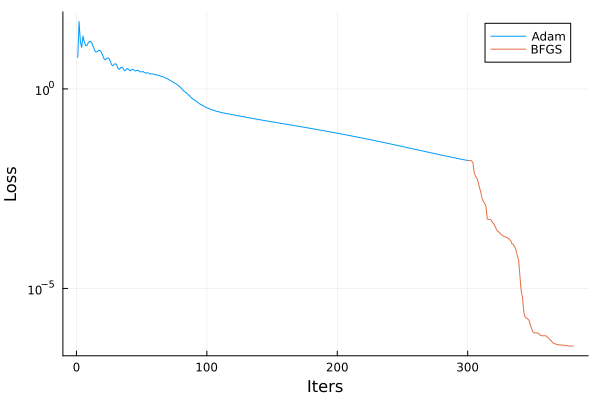

In [30]:
using Lux, DiffEqFlux, OrdinaryDiffEq, ComponentArrays
using Optimization, OptimizationOptimJL, OptimizationOptimisers
using Random, Plots
rng = Random.Xoshiro(0)

# # True solution: $u^3$ and multiplied by a matrix
# function trueODEfunc(du, u, p, t)
#     true_A = [-0.1 2.0; -2.0 -0.1]
#     du .= ((u.^3)'true_A)'
# end

function trueODEfunc(du, u, p, t)
    du[1] = -0.7*u[1] #+ 0.6*u.^3
    du[2] = -0.2*u[2]
    return du
end

# Generate data from the true function
u0 = [2.0; 0.0]
datasize = 31
tspan = (0.0, 1.5)
tsteps = range(tspan[begin], tspan[end], length = datasize)
prob_trueode = ODEProblem(trueODEfunc, u0, tspan)
ode_data = Array(solve(prob_trueode, Tsit5(), saveat = tsteps))

# Define a `NeuralODE` problem with a neural network from `Lux.jl`.
dudt2 = Lux.Chain(
    x -> x.^3,
    Lux.Dense(2, 50, tanh),
    Lux.Dense(50, 2)
)

p, st = Lux.setup(rng, dudt2) |> f64
prob_neuralode = NeuralODE(dudt2, tspan, Tsit5(), saveat = tsteps)

# Predicted output
predict_neuralode(p) = Array(prob_neuralode(u0, p, st)[1])

# Loss function
# Optimization.jl v4 only accept a scalar output
function loss_neuralode(p)
    pred = predict_neuralode(p)
    l2loss = sum(abs2, ode_data .- pred)
    return l2loss
end

# Callback function
anim = Animation()
lossrecord=Float64[]
callback = function (state, l; doplot = true)
    if doplot
        pred = predict_neuralode(state.u)
        plt = scatter(tsteps, ode_data[1,:], label = "data")
        scatter!(plt, tsteps, pred[1,:], label = "prediction")
        frame(anim)
        push!(lossrecord, l)
    else
        println(l)
    end
    return false
end

# Try the callback function to see if it works.
pinit = ComponentArray(p)
callback((; u = pinit), loss_neuralode(pinit); doplot=false)

# Use https://github.com/SciML/Optimization.jl to solve the problem and https://github.com/FluxML/Zygote.jl for automatic differentiation (AD).
adtype = Optimization.AutoZygote()

# Define a [function](https://docs.sciml.ai/Optimization/stable/API/optimization_function/) to optimize with AD.
optf = Optimization.OptimizationFunction((x, p) -> loss_neuralode(x), adtype)

# Define an `OptimizationProblem`
optprob = Optimization.OptimizationProblem(optf, pinit)

# Solve the `OptimizationProblem` using the ADAM optimizer first to get a rough estimate.
result_neuralode = Optimization.solve(
    optprob,
    OptimizationOptimisers.Adam(0.05),
    callback = callback,
    maxiters = 300
)

println("Loss is: ", loss_neuralode(result_neuralode.u))

# Use another optimizer (BFGS) to refine the solution.
optprob2 = remake(optprob; u0 = result_neuralode.u)

result_neuralode2 = Optimization.solve(
    optprob2,
    Optim.BFGS(; initial_stepnorm = 0.01),
    callback = callback,
    allow_f_increases = false
)

println("Loss is: ", loss_neuralode(result_neuralode2.u))

# Visualize the fitting process
mp4(anim, fps=15)

#---
lossrecord
plot(lossrecord[1:300], xlabel="Iters", ylabel="Loss", lab="Adam", yscale=:log10)
plot!(300:length(lossrecord), lossrecord[300:end], lab="BFGS")